# Supervised Machine Learning: Regression and Classification

In [1]:
import sys
sys.path.insert(0, './work/machine_learning/01 - supervised_ml_regression_classification')

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, unix_timestamp, col, regexp_replace
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation
import pyspark.pandas as ps
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

import numpy as np
import math

/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Pyspark config

In [2]:
# SPAWN A SPARKSESSION
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.cores", "12").\
        config("spark.executor.memory", "1024mb").\
        getOrCreate()

In [429]:
# Read dataset for this course and cache() it

df = ps.read_csv("hdfs://namenode:9000/data/cardio_base.csv", index_col="id")
df = df.astype(int)

df = ps.get_dummies(df, columns=['gender', 'smoke'], dtype='int', )

df['height_weight_mul'] = df['height'] * df['weight']

df = df.loc[df['ap_hi'] < 500]

# Why cache dataframe?
# Reusing Data: Caching is optimal when you need to perform multiple operations on the same dataset to 
#    avoid reading from storage repeatedly.
# Frequent Subset Access: Useful for frequently accessing small subsets of a large dataset, reducing the 
#    need to load the entire dataset repeatedly.
df_cached = df.spark.cache()

df_cached.head(10)

,age,height,weight,ap_hi,ap_lo,cholesterol,gender_1,gender_2,smoke_0,smoke_1,height_weight_mul
id,,,,,,,,,,,
0,18393,168,62,110,80,1,0,1,1,0,10416
1,20228,156,85,140,90,3,1,0,1,0,13260
2,18857,165,64,130,70,3,1,0,1,0,10560
3,17623,169,82,150,100,1,0,1,1,0,13858
4,17474,156,56,100,60,1,1,0,1,0,8736
8,21914,151,67,120,80,2,1,0,1,0,10117
9,22113,157,93,130,80,3,1,0,1,0,14601
12,22584,178,95,130,90,3,0,1,1,0,16910
13,17668,158,71,110,70,1,1,0,1,0,11218


## Week 3

### Logistic Regression

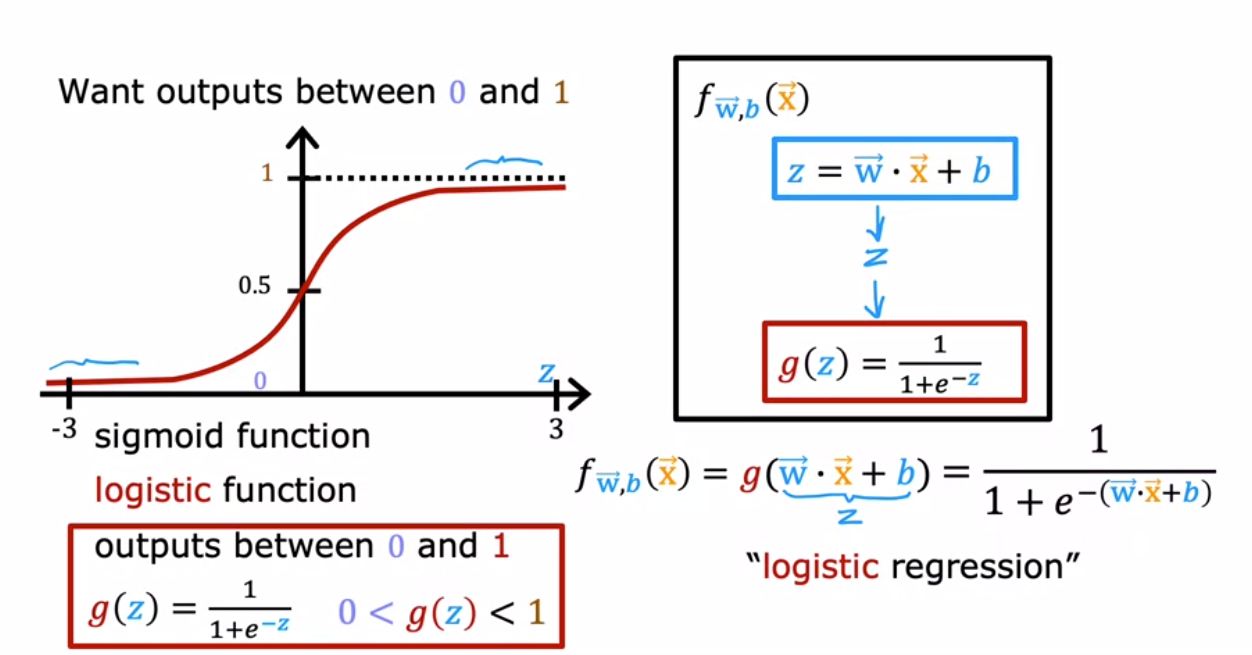

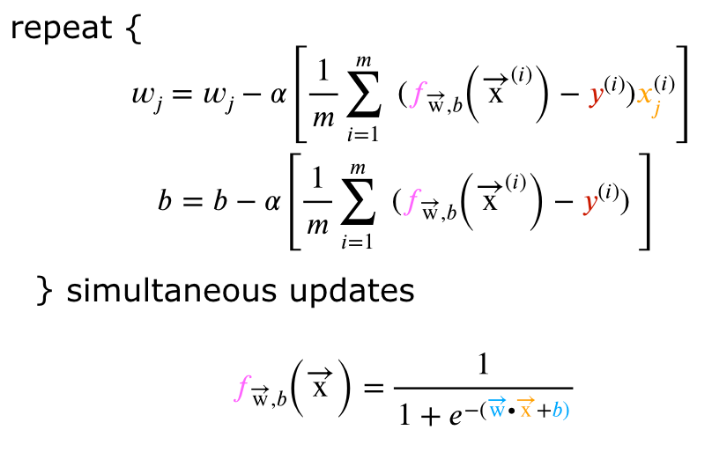


Log loss function used in logistic regression and binary classification 

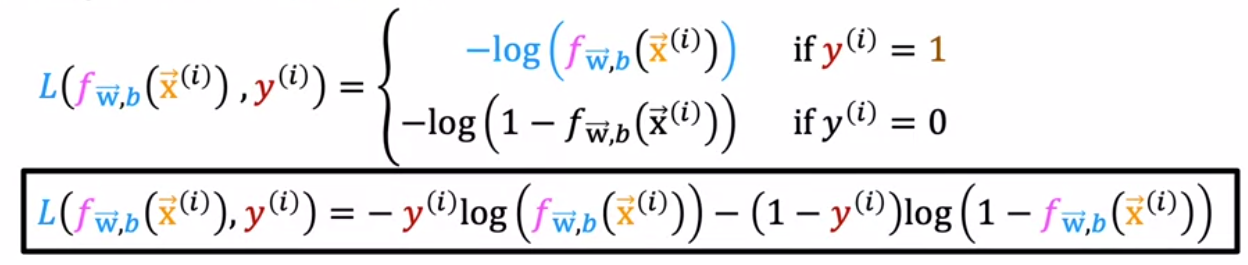

##### Implementation of Multiple Linear Regression w/ MinMaxScaling and Ridge Reg in Spark using pyspark.pandas API

In [430]:
# LINEAR REGRESSION AGE IN DAYS AND WEIGHT TO PREDICT SYSTOLIC BLOOD PRESSURE
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

sampled_df = df_cached.sample(frac=0.9)

# Convert pandas dataframe to Spark dataframe
spark_df = sampled_df.to_spark()

# Split the data into a training and test set
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_df, test_df = spark_df.randomSplit([train_ratio, test_ratio], seed=42)

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [444]:

# Create the scaler object
columns_to_scale = ["height","height_weight_mul"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalers_model = pipeline.fit(train_df)
scaled_train_df = scalers_model.transform(train_df)
scaled_test_df = scalers_model.transform(test_df)

assembler = VectorAssembler(inputCols=["height_scaled","height_weight_mul_scaled"], outputCol="features")
assembled_scaled_train_df = assembler.transform(scaled_train_df)
assembled_scaled_test_df = assembler.transform(scaled_test_df)

# Show the scaled DataFrame
assembled_scaled_train_df.show(10)

+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+-----------------+----------+---------------------+--------------------+------------------------+--------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1|height_weight_mul|height_vec|height_weight_mul_vec|       height_scaled|height_weight_mul_scaled|            features|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+-----------------+----------+---------------------+--------------------+------------------------+--------------------+
|10859|   159|    59|  120|   80|          1|       1|       0|      1|      0|             9381|   [159.0]|             [9381.0]|[0.5210526315789473]|    [0.21746835443037...|[0.52105263157894...|
|10878|   175|    59|  120|   80|          1|       1|       0|      1|      0|            10325|   [175.0]|            [10325.0]|[0.6052631578947368]|    [0.2440225035161744]|[0.60526315789473...|
|14275|   

In [512]:
# Create a Linear Regression model with L1 regularization (ridge)
lr = LogisticRegression(featuresCol="features", labelCol="gender_1").setRegParam(0.01).setElasticNetParam(.5)

# Fit the model to the data
lr_model = lr.fit(assembled_scaled_train_df)

#print("Coefficients: %s" % str(lr_model.coefficients))
#print("Intercept: %s" % str(lr_model.intercept))
#
pred = lr_model.transform(assembled_scaled_test_df)
#pred.show(10)
#
## Create a RegressionEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="gender_1", predictionCol="prediction")
#
#
## Calculate areaUnderROC
a_roc = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
#
## Calculate MSE
#mse = evaluator.evaluate(pred, {evaluator.metricName: "mse"})
#
## Calculate MAE
#mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
#
## Calculate R2
#r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
#
print("accuracy:", a_roc)
#print("MSE:", mse)
#print("MAE:", mae)
#print("R2:", r2)

accuracy: 0.7703465579426062


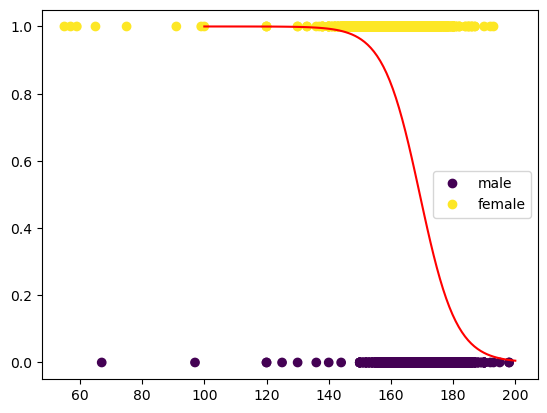

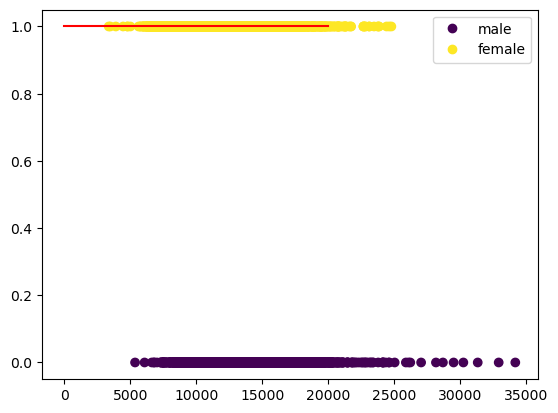

In [513]:
# Define the x values for the regression line
x = [np.linspace(100, 200, 100), np.linspace(0, 20000, 100)]

# Calculate the y values for the regression line
def logistic_regression(x, coefficients, bias):
    z = (np.dot(coefficients, x)) + bias
    return z, 1 / (1 + np.exp(-z))

num_features = len(assembled_scaled_train_df.first()["features"])

scaling_params = [(scalers_model.stages[num_features+i].originalMin.toArray(), scalers_model.stages[num_features+i].originalMax.toArray()) for i in range(num_features)]
reverted_coefficients = [lr_model.coefficients[i] / (scaling_params[i][1] - scaling_params[i][0])[0] for i in range(num_features)]
reverted_bias = [lr_model.intercept - np.dot(reverted_coefficients[i], scalers_model.stages[num_features+i].originalMin.toArray()) for i in range(num_features)]
reverted_whole_bias = lr_model.intercept - np.sum([reverted_coefficients[i] * scaling_params[i][0] for i in range(num_features)])

classes = ['male', 'female']
for i in range(num_features):
    z, prob = logistic_regression(x[i], reverted_coefficients[i], reverted_bias[i])
    scatter = plt.scatter(assembled_scaled_test_df.select(columns_to_scale[i]).collect(), assembled_scaled_test_df.select("gender_1").collect(), c=assembled_scaled_test_df.select('gender_1').collect(), label='Gender')
    plt.plot(x[i], prob, color='red', label='Regression Line')
    
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)

    plt.show()


In [514]:
print(reverted_coefficients)
print(reverted_bias)
print(reverted_whole_bias)

[-0.17046912706343612, 0.0]
[array([28.85897986]), array([18.63083224])]
28.858979860192676


Text(0.5, 0, 'height')

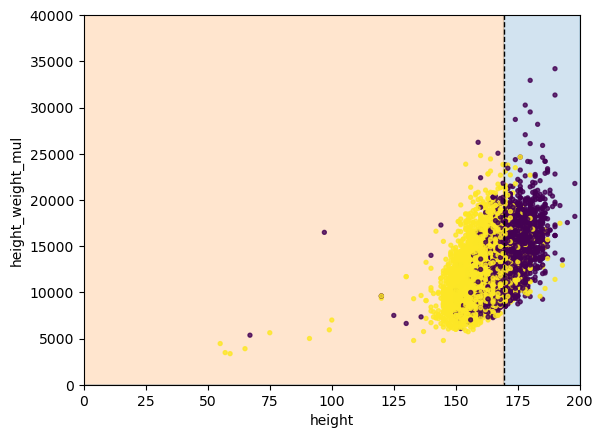

In [522]:
# Calculate the intercept and gradient of the decision boundary.
xmin, xmax = 0, 200
ymin, ymax = 0, 40000



#c = -reverted_whole_bias/reverted_coefficients[1]

c = -reverted_whole_bias/(reverted_coefficients[1]+1e-10 )
m = -reverted_coefficients[0]/(reverted_coefficients[1]+1e-10 )


#m = -reverted_coefficients[0]/reverted_coefficients[1]

xd = np.array([xmin, xmax])
yd = m*xd + c

plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)
plt.scatter(assembled_scaled_test_df.select(columns_to_scale[0]).collect(), 
            assembled_scaled_test_df.select(columns_to_scale[1]).collect(), 
            c=assembled_scaled_test_df.select('gender_1').collect(),
            s=8, alpha=0.8)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(f'{columns_to_scale[1]}')
plt.xlabel(f'{columns_to_scale[0]}')



In [523]:
z, probs = logistic_regression([[180], [120]], reverted_coefficients, reverted_whole_bias)
probs

array([0.13877965])

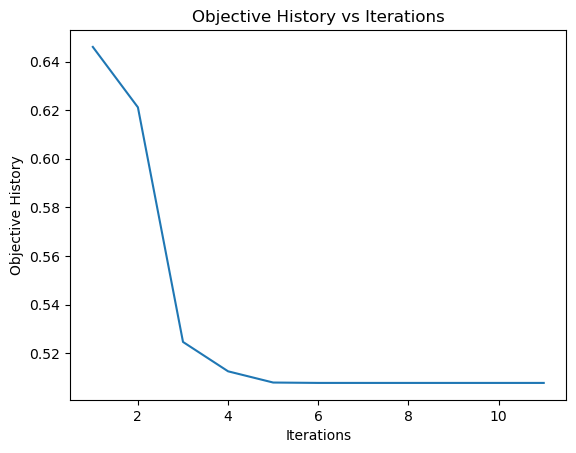

In [524]:
# Get the objective history from the lr_model summary
objective_history = lr_model.summary.objectiveHistory

# Create a list of iterations
iterations = list(range(1, len(objective_history) + 1))

plt.plot(iterations, objective_history)
plt.xlabel('Iterations')
plt.ylabel('Objective History')
plt.title('Objective History vs Iterations')
plt.show()

### Regularization

Gradient descent with regularization 

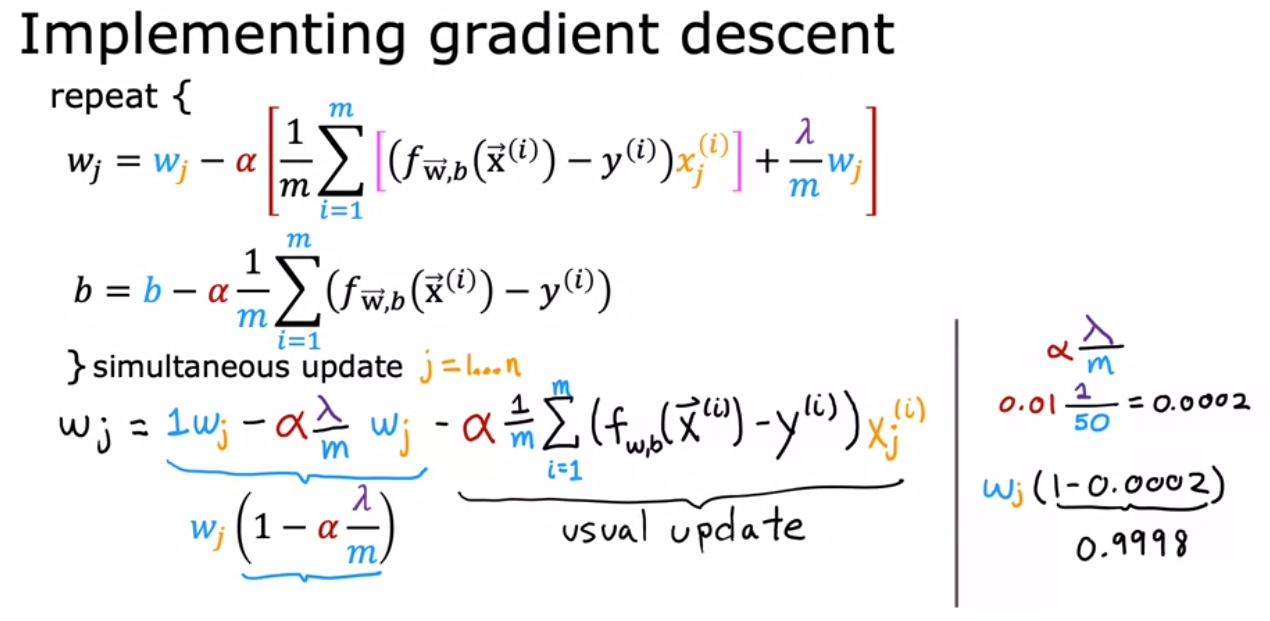